In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../input/bri-data-hackathon-cr-optimization/train.csv')
df.head()

,periode,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


## Workflow
1. Working with time series
    - Data Preprocessing
    - Visualization: Multiple vs Multivariate Time Series
2. Modeling using fbprophet
    - Baseline Model
    - Trend Component
    - Seasonality Component
    - Holiday Effects
    - Adding Regressors
3. Forecasting Evaluation
    - Train test split
    - Evaluation Metrics: RMSLE
    - Expanding Window Cross Validation
4. Hyperparameter Tuning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   periode                     425 non-null    object 
 1   cash_in_echannel            425 non-null    float64
 2   cash_out_echannel           425 non-null    float64
 3   cash_in_kantor              425 non-null    float64
 4   cash_out_kantor             425 non-null    float64
 5   cr_ketetapan_total_bkn_sum  425 non-null    float64
 6   giro                        425 non-null    float64
 7   deposito                    425 non-null    float64
 8   kewajiban_lain              425 non-null    float64
 9   tabungan                    425 non-null    float64
 10  rata_dpk_mingguan           425 non-null    float64
 11  kas_kantor                  425 non-null    float64
 12  kas_echannel                425 non-null    float64
dtypes: float64(12), object(1)
memory us

In [4]:
desc = pd.read_csv('../input/bri-data-hackathon-cr-optimization/data_description.csv')
desc

,variabel,sample Data,Deskripsi
0,cash_in_echannel,7.924471e+09,Total Kas Masuk pada kas eChannel (ATM dan CRM)
1,cash_out_echannel,7.924471e+09,Total Kas keluar pada kas eChannel (ATM dan CRM)
2,cash_in_kantor,1.372300e+10,Total kas masuk pada kas kantor
3,cash_out_kantor,-2.767644e+10,Total kas keluar pada kas kantor
4,cr_ketetapan_total_bkn_sum,4.350000e+00,Maksimum cash ratio yang dii tetapkan kantor p...
5,giro,5.355247e+10,Total simpanan giro
6,deposito,1.344615e+10,Total simpanan deposito
7,kewajiban_lain,3.490872e+09,"Simpanan selain giro tabungan dan deposito ,sa..."
8,tabungan,1.659893e+11,Total simpanan tabungan
9,rata_dpk_mingguan,2.401906e+11,rata - rata saldo DPK mingguan


In [5]:
df['periode'] = pd.to_datetime(df['periode'], dayfirst=True)
df.sort_values('periode', inplace=True)

In [6]:
df['periode'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     425
unique                    425
top       2020-02-11 00:00:00
freq                        1
first     2019-07-31 00:00:00
last      2020-09-30 00:00:00
Name: periode, dtype: object

## Visalize

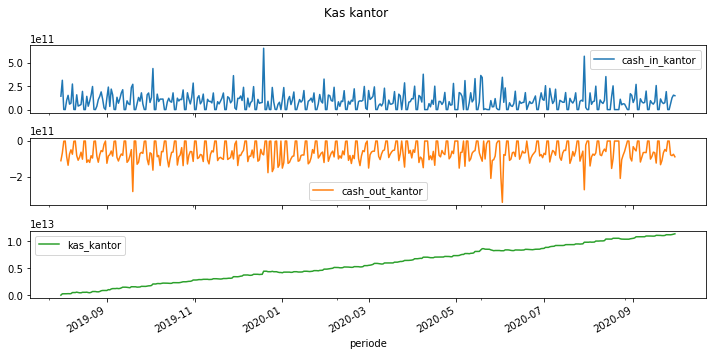

In [7]:
kas_kantor = df.set_index('periode')[['cash_in_kantor','cash_out_kantor','kas_kantor']].plot(subplots=True, figsize=(10,5))
plt.suptitle('Kas kantor')
plt.tight_layout();

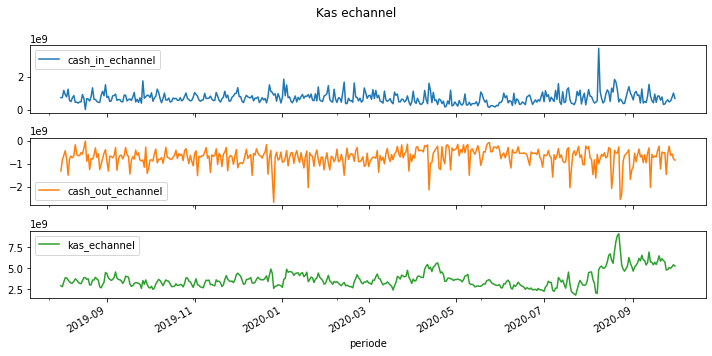

In [8]:
kas_echannel = df.set_index('periode')[['cash_in_echannel','cash_out_echannel','kas_echannel']].plot(subplots=True, figsize=(10,5))
plt.suptitle('Kas echannel')
plt.tight_layout();

In [9]:
kas_kantor = df.groupby(['periode']) \
                [['cash_in_kantor', 'cash_out_kantor','kas_kantor']] \
                .sum().reset_index()
kas_kantor.head()

,periode,cash_in_kantor,cash_out_kantor,kas_kantor
0,2019-07-31,1.436722e+11,-1.106104e+11,1.928940e+09
1,2019-08-01,3.144131e+11,-6.710987e+10,2.492322e+11
2,2019-08-02,1.251294e+09,-1.142332e+09,2.493411e+11
3,2019-08-03,0.000000e+00,0.000000e+00,2.493411e+11
4,2019-08-04,9.883331e+10,-8.729274e+10,2.608817e+11


In [10]:
kas_echannel = df.groupby(['periode']) \
                [['cash_in_echannel', 'cash_out_echannel','kas_echannel']] \
                .sum().reset_index()
kas_echannel.head()

,periode,cash_in_echannel,cash_out_echannel,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,3.874250e+09


### Baseline Model

In [11]:
total_cash_in_kantor = df[['periode','cash_in_kantor']].rename(
    columns={'periode':'ds',
            'cash_in_kantor':'y'})
total_cash_in_kantor.head()

,ds,y
0,2019-07-31,1.436722e+11
1,2019-08-01,3.144131e+11
2,2019-08-02,1.251294e+09
3,2019-08-03,0.000000e+00
4,2019-08-04,9.883331e+10


In [12]:
total_cash_out_kantor = df[['periode','cash_out_kantor']].rename(
    columns={'periode':'ds',
            'cash_out_kantor':'y'})
total_cash_out_kantor.head()

,ds,y
0,2019-07-31,-1.106104e+11
1,2019-08-01,-6.710987e+10
2,2019-08-02,-1.142332e+09
3,2019-08-03,0.000000e+00
4,2019-08-04,-8.729274e+10


In [13]:
total_cash_in_echannel = df[['periode','cash_in_echannel']].rename(
    columns={'periode':'ds',
            'cash_in_echannel':'y'})
total_cash_in_echannel.head()

,ds,y
0,2019-07-31,7.303000e+08
1,2019-08-01,7.322000e+08
2,2019-08-02,1.169800e+09
3,2019-08-03,9.134500e+08
4,2019-08-04,7.752500e+08


In [14]:
total_cash_out_echannel = df[['periode','cash_out_echannel']].rename(
    columns={'periode':'ds',
            'cash_out_echannel':'y'})
total_cash_out_echannel.head()

,ds,y
0,2019-07-31,-1.304400e+09
1,2019-08-01,-8.321500e+08
2,2019-08-02,-6.214000e+08
3,2019-08-03,-4.240500e+08
4,2019-08-04,-7.779500e+08


In [15]:
total_kas_kantor = df[['periode','kas_kantor','cash_in_kantor','cash_out_kantor']].rename(
    columns={'periode':'ds',
            'kas_kantor':'y'})
total_kas_kantor.head()

,ds,y,cash_in_kantor,cash_out_kantor
0,2019-07-31,1.928940e+09,1.436722e+11,-1.106104e+11
1,2019-08-01,2.492322e+11,3.144131e+11,-6.710987e+10
2,2019-08-02,2.493411e+11,1.251294e+09,-1.142332e+09
3,2019-08-03,2.493411e+11,0.000000e+00,0.000000e+00
4,2019-08-04,2.608817e+11,9.883331e+10,-8.729274e+10


In [16]:
total_echannel = df[['periode','kas_echannel','cash_in_echannel','cash_out_echannel']].rename(
    columns={'periode':'ds',
            'kas_echannel':'y'})
total_echannel.head()

,ds,y,cash_in_echannel,cash_out_echannel
0,2019-07-31,2.939100e+09,7.303000e+08,-1.304400e+09
1,2019-08-01,2.839150e+09,7.322000e+08,-8.321500e+08
2,2019-08-02,3.387550e+09,1.169800e+09,-6.214000e+08
3,2019-08-03,3.876950e+09,9.134500e+08,-4.240500e+08
4,2019-08-04,3.874250e+09,7.752500e+08,-7.779500e+08


In [17]:
from fbprophet import Prophet
import plotly.io as pio
from fbprophet.plot import plot_plotly, plot_components_plotly
from datetime import date
from fbprophet import hdays

### Holiday effect

In [18]:
model_cash_in_kantor = Prophet()
model_cash_in_kantor.add_country_holidays(country_name='ID')
model_cash_in_kantor.fit(total_cash_in_kantor)

model_cash_in_kantor.train_holiday_names

/opt/conda/lib/python3.7/site-packages/fbprophet/hdays.py:105: Warning: We only support Nyepi holiday from 2009 to 2019
  warnings.warn(warning_msg, Warning)


0               New Year's Day
1             Chinese New Year
2        Day of Silence/ Nyepi
3     Ascension of the Prophet
4                    Labor Day
5           Ascension of Jesus
6            Buddha's Birthday
7                Pancasila Day
8                  Eid al-Fitr
9             Independence Day
10      Feast of the Sacrifice
11        Birth of the Prophet
12                   Christmas
13            Islamic New Year
dtype: object

In [19]:
holiday = pd.DataFrame({
    'holiday': 'tanggal merah',
    'ds': pd.to_datetime(['2019-01-01','2019-02-05','2019-03-07','2019-04-03','2019-04-19',
                          '2019-05-01','2019-05-19','2019-05-30','2019-06-01','2019-06-03',
                          '2019-06-04','2019-06-05','2019-06-07','2019-06-06','2019-08-11',
                          '2019-08-17','2019-09-01','2019-11-09','2019-12-24','2019-12-25',# past date, historical data 
                          '2020-01-01','2020-01-25','2020-03-22','2020-03-25','2020-04-01',
                          '2020-05-01','2020-05-07','2020-05-21','2020-05-22','2020-05-24',
                          '2020-05-25','2020-06-01','2020-07-31','2020-08-17','2020-08-20',
                          '2020-08-21','2020-10-28','2020-10-29','2020-10-30'])}) # future date, to be forecasted
holiday

,holiday,ds
0,tanggal merah,2019-01-01
1,tanggal merah,2019-02-05
2,tanggal merah,2019-03-07
3,tanggal merah,2019-04-03
4,tanggal merah,2019-04-19
5,tanggal merah,2019-05-01
6,tanggal merah,2019-05-19
7,tanggal merah,2019-05-30
8,tanggal merah,2019-06-01
9,tanggal merah,2019-06-03


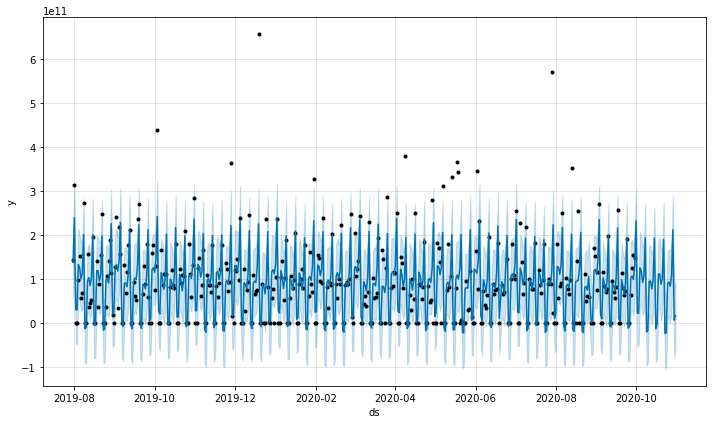

In [20]:
# fitting model
model_cash_in_kantor = Prophet(
    n_changepoints=25, # trend flexibility
    changepoint_range=0.8, # trend flexibility
    changepoint_prior_scale=0.05, # trend flexibility
    weekly_seasonality=3, # seasonality fourier order
    yearly_seasonality=False, # remove seasonality
    holidays=holiday# new year eve effects
    )
## add monthly seasonality
model_cash_in_kantor.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_cash_in_kantor.fit(total_cash_in_kantor)

# forecasting
future = model_cash_in_kantor.make_future_dataframe(periods=31, freq='D')
forecast_cash_in_kantor = model_cash_in_kantor.predict(future)

# visualize
fig = model_cash_in_kantor.plot(forecast_cash_in_kantor)

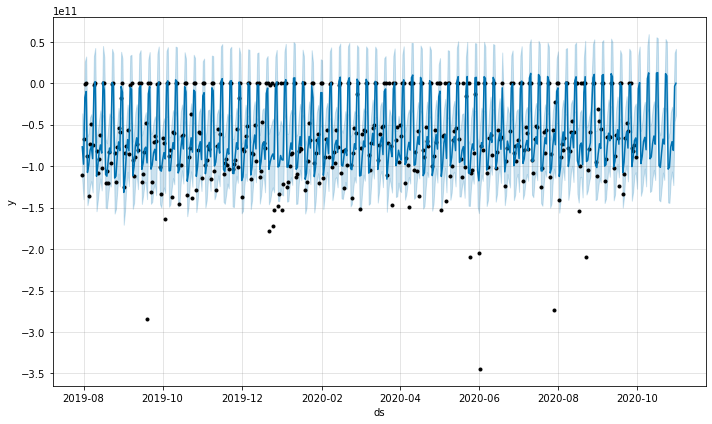

In [21]:
# fitting model
model_cash_out_kantor = Prophet(
    n_changepoints=25, # trend flexibility
    changepoint_range=0.8, # trend flexibility
    changepoint_prior_scale=0.05, # trend flexibility
    weekly_seasonality=3, # seasonality fourier order
    yearly_seasonality=False, # remove seasonality
    holidays=holiday# new year eve effects
    )
## add monthly seasonality
model_cash_out_kantor.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_cash_out_kantor.fit(total_cash_out_kantor)

# forecasting
future = model_cash_out_kantor.make_future_dataframe(periods=31, freq='D')
forecast_cash_out_kantor = model_cash_out_kantor.predict(future)

# visualize
fig = model_cash_out_kantor.plot(forecast_cash_out_kantor)

In [22]:
forecasted_cash_in_kantor = forecast_cash_in_kantor[['ds', 'yhat']].tail(31) \
                        .rename(columns={'yhat': 'cash_in_kantor'})
forecasted_cash_in_kantor

,ds,cash_in_kantor
425,2020-10-01,2.327501e+11
426,2020-10-02,2.353111e+10
427,2020-10-03,2.277853e+10
428,2020-10-04,1.261336e+11
429,2020-10-05,1.185191e+11
430,2020-10-06,9.308969e+10
431,2020-10-07,1.060961e+11
432,2020-10-08,1.941664e+11
433,2020-10-09,-1.972332e+10
434,2020-10-10,-1.652923e+10


In [23]:
actual_cash_in_kantor = total_cash_in_kantor.rename(columns={'y': 'cash_in_kantor'})
actual_cash_in_kantor

,ds,cash_in_kantor
0,2019-07-31,1.436722e+11
1,2019-08-01,3.144131e+11
2,2019-08-02,1.251294e+09
3,2019-08-03,0.000000e+00
4,2019-08-04,9.883331e+10
...,...,...
420,2020-09-26,0.000000e+00
421,2020-09-27,6.466720e+10
422,2020-09-28,1.264345e+11
423,2020-09-29,1.548627e+11


In [24]:
future_cash_in_kantor = pd.concat([actual_cash_in_kantor, forecasted_cash_in_kantor])
future_cash_in_kantor

,ds,cash_in_kantor
0,2019-07-31,1.436722e+11
1,2019-08-01,3.144131e+11
2,2019-08-02,1.251294e+09
3,2019-08-03,0.000000e+00
4,2019-08-04,9.883331e+10
...,...,...
451,2020-10-27,8.414652e+10
452,2020-10-28,1.084591e+11
453,2020-10-29,2.123785e+11
454,2020-10-30,7.116968e+09


In [25]:
forecasted_cash_out_kantor = forecast_cash_out_kantor[['ds', 'yhat']].tail(31) \
                        .rename(columns={'yhat': 'cash_out_kantor'})
forecasted_cash_out_kantor

,ds,cash_out_kantor
425,2020-10-01,-8.691369e+10
426,2020-10-02,-6.447497e+09
427,2020-10-03,7.263532e+08
428,2020-10-04,-9.693877e+10
429,2020-10-05,-8.802350e+10
430,2020-10-06,-7.033256e+10
431,2020-10-07,-6.526681e+10
432,2020-10-08,-8.023046e+10
433,2020-10-09,5.570912e+09
434,2020-10-10,1.251110e+10


In [26]:
actual_cash_out_kantor = total_cash_out_kantor.rename(columns={'y': 'cash_out_kantor'})
actual_cash_out_kantor

,ds,cash_out_kantor
0,2019-07-31,-1.106104e+11
1,2019-08-01,-6.710987e+10
2,2019-08-02,-1.142332e+09
3,2019-08-03,0.000000e+00
4,2019-08-04,-8.729274e+10
...,...,...
420,2020-09-26,0.000000e+00
421,2020-09-27,-7.829833e+10
422,2020-09-28,-8.203374e+10
423,2020-09-29,-7.443120e+10


In [27]:
future_cash_out_kantor = pd.concat([actual_cash_out_kantor, forecasted_cash_out_kantor])
future_cash_out_kantor

,ds,cash_out_kantor
0,2019-07-31,-1.106104e+11
1,2019-08-01,-6.710987e+10
2,2019-08-02,-1.142332e+09
3,2019-08-03,0.000000e+00
4,2019-08-04,-8.729274e+10
...,...,...
451,2020-10-27,-7.699624e+10
452,2020-10-28,-7.047215e+10
453,2020-10-29,-8.103612e+10
454,2020-10-30,-3.563457e+09


In [28]:
future_cash_in_kantor['cash_out_kantor'] = future_cash_out_kantor.iloc[:,1]
future_regressor_kantor = future_cash_in_kantor

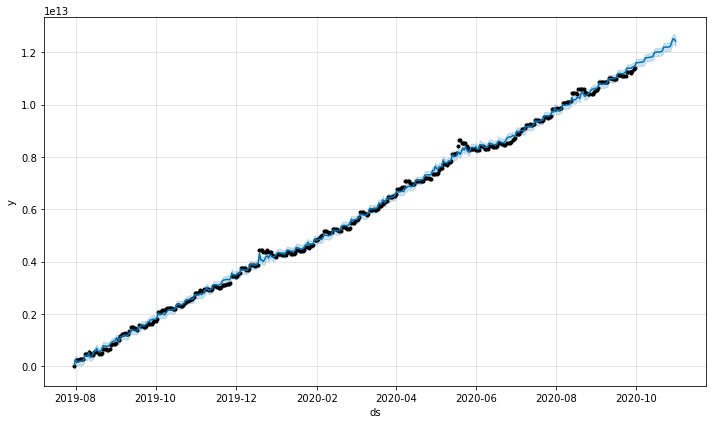

In [29]:
# fitting model
model_kas_kantor = Prophet(
#     n_changepoints=25, # trend flexibility
#     changepoint_range=0.8, # trend flexibility
#     changepoint_prior_scale=0.05, # trend flexibility
#     weekly_seasonality=3, # seasonality fourier order
#     yearly_seasonality=False, # remove seasonality
    holidays=holiday # new year eve effects
    )
## add regressor
model_kas_kantor.add_regressor('cash_in_kantor')
model_kas_kantor.add_regressor('cash_out_kantor')
model_kas_kantor.fit(total_kas_kantor)

# forecasting
## use dataframe with regressor, instead of just `ds` column
forecast_kas_kantor = model_kas_kantor.predict(future_regressor_kantor)

# visualize
fig = model_kas_kantor.plot(forecast_kas_kantor)

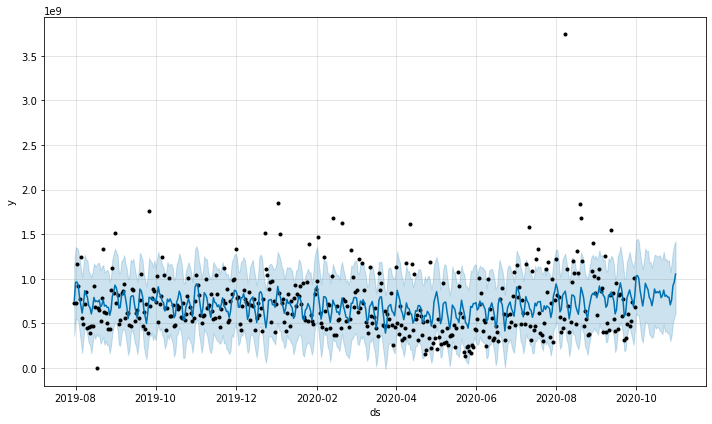

In [30]:
# fitting model
model_cash_in_echannel = Prophet(
    n_changepoints=25, # trend flexibility
    changepoint_range=0.8, # trend flexibility
    changepoint_prior_scale=0.05, # trend flexibility
    weekly_seasonality=3, # seasonality fourier order
    yearly_seasonality=False, # remove seasonality
    holidays=holiday# new year eve effects
    )
## add monthly seasonality
model_cash_in_echannel.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_cash_in_echannel.fit(total_cash_in_echannel)

# forecasting
future = model_cash_in_echannel.make_future_dataframe(periods=31, freq='D')
forecast_cash_in_echannel = model_cash_in_echannel.predict(future)

# visualize
fig = model_cash_in_echannel.plot(forecast_cash_in_echannel)

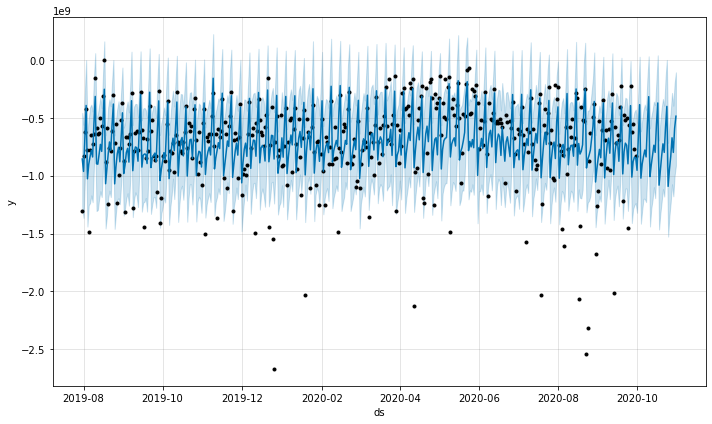

In [31]:
# fitting model
model_cash_out_echannel = Prophet(
    n_changepoints=25, # trend flexibility
    changepoint_range=0.8, # trend flexibility
    changepoint_prior_scale=0.05, # trend flexibility
    weekly_seasonality=3, # seasonality fourier order
    yearly_seasonality=False, # remove seasonality
    holidays=holiday# new year eve effects
    )
## add monthly seasonality
model_cash_out_echannel.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_cash_out_echannel.fit(total_cash_out_echannel)

# forecasting
future = model_cash_out_echannel.make_future_dataframe(periods=31, freq='D')
forecast_cash_out_echannel = model_cash_out_echannel.predict(future)

# visualize
fig = model_cash_out_echannel.plot(forecast_cash_out_echannel)

In [32]:
forecasted_cash_in_echannel = forecast_cash_in_echannel[['ds', 'yhat']].tail(31) \
                        .rename(columns={'yhat': 'cash_in_echannel'})
forecasted_cash_in_echannel

,ds,cash_in_echannel
425,2020-10-01,1.030758e+09
426,2020-10-02,1.036348e+09
427,2020-10-03,1.003776e+09
428,2020-10-04,8.695033e+08
429,2020-10-05,7.844202e+08
430,2020-10-06,6.942928e+08
431,2020-10-07,7.947040e+08
432,2020-10-08,9.494591e+08
433,2020-10-09,9.105966e+08
434,2020-10-10,8.782546e+08


In [33]:
actual_cash_in_echannel = total_cash_in_echannel.rename(columns={'y': 'cash_in_echannel'})
actual_cash_in_echannel

,ds,cash_in_echannel
0,2019-07-31,7.303000e+08
1,2019-08-01,7.322000e+08
2,2019-08-02,1.169800e+09
3,2019-08-03,9.134500e+08
4,2019-08-04,7.752500e+08
...,...,...
420,2020-09-26,4.692000e+08
421,2020-09-27,5.272500e+08
422,2020-09-28,7.438000e+08
423,2020-09-29,1.009250e+09


In [34]:
future_cash_in_echannel = pd.concat([actual_cash_in_echannel, forecasted_cash_in_echannel])
future_cash_in_echannel

,ds,cash_in_echannel
0,2019-07-31,7.303000e+08
1,2019-08-01,7.322000e+08
2,2019-08-02,1.169800e+09
3,2019-08-03,9.134500e+08
4,2019-08-04,7.752500e+08
...,...,...
451,2020-10-27,7.072417e+08
452,2020-10-28,7.636744e+08
453,2020-10-29,9.195329e+08
454,2020-10-30,9.628007e+08


In [35]:
forecasted_cash_out_echannel = forecast_cash_out_echannel[['ds', 'yhat']].tail(31) \
                        .rename(columns={'yhat': 'cash_out_echannel'})
forecasted_cash_out_echannel

,ds,cash_out_echannel
425,2020-10-01,-9.536334e+08
426,2020-10-02,-6.663671e+08
427,2020-10-03,-3.864937e+08
428,2020-10-04,-1.021325e+09
429,2020-10-05,-8.975525e+08
430,2020-10-06,-8.327890e+08
431,2020-10-07,-7.785938e+08
432,2020-10-08,-8.379375e+08
433,2020-10-09,-5.500289e+08
434,2020-10-10,-3.175595e+08


In [36]:
actual_cash_out_echannel = total_cash_out_echannel.rename(columns={'y': 'cash_out_echannel'})
actual_cash_out_echannel

,ds,cash_out_echannel
0,2019-07-31,-1.304400e+09
1,2019-08-01,-8.321500e+08
2,2019-08-02,-6.214000e+08
3,2019-08-03,-4.240500e+08
4,2019-08-04,-7.779500e+08
...,...,...
420,2020-09-26,-2.264000e+08
421,2020-09-27,-6.187500e+08
422,2020-09-28,-5.562000e+08
423,2020-09-29,-7.721000e+08


In [37]:
future_cash_out_echannel = pd.concat([actual_cash_out_echannel, forecasted_cash_out_echannel])
future_cash_out_echannel

,ds,cash_out_echannel
0,2019-07-31,-1.304400e+09
1,2019-08-01,-8.321500e+08
2,2019-08-02,-6.214000e+08
3,2019-08-03,-4.240500e+08
4,2019-08-04,-7.779500e+08
...,...,...
451,2020-10-27,-8.346450e+08
452,2020-10-28,-6.728315e+08
453,2020-10-29,-7.991521e+08
454,2020-10-30,-5.911657e+08


In [38]:
future_cash_in_echannel['cash_out_echannel'] = future_cash_out_echannel.iloc[:,1]
future_regressor_echannel = future_cash_in_echannel

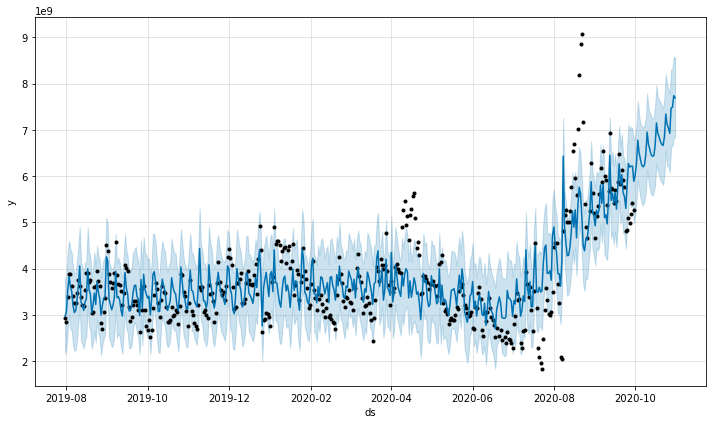

In [39]:
# fitting model
model_kas_echannel = Prophet(
    holidays=holiday # new year eve effects
    )
## add regressor
model_kas_echannel.add_regressor('cash_in_echannel')
model_kas_echannel.add_regressor('cash_out_echannel')
model_kas_echannel.fit(total_echannel)

# forecasting
## use dataframe with regressor, instead of just `ds` column
forecast_kas_echannel = model_kas_echannel.predict(future_regressor_echannel)

# visualize
fig = model_kas_echannel.plot(forecast_kas_echannel)

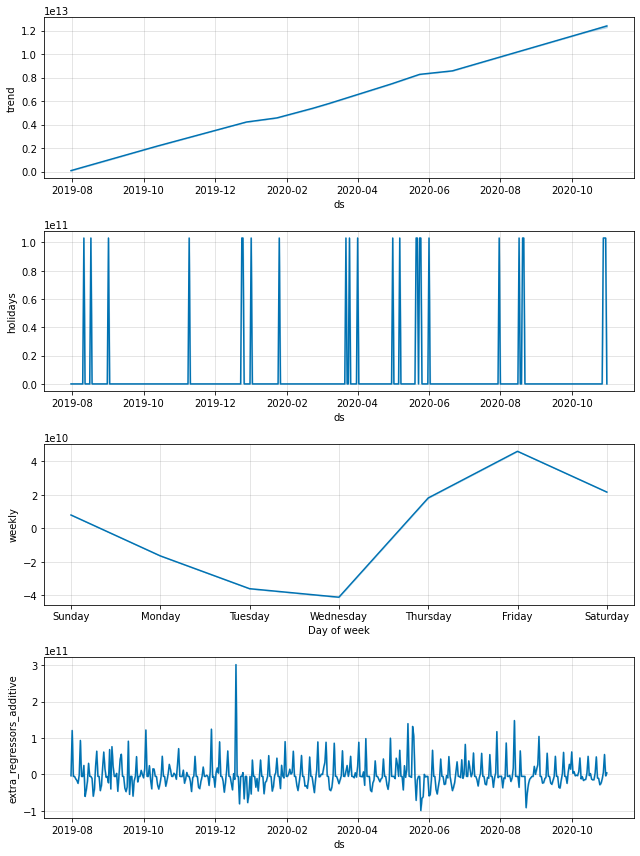

In [40]:
fig = model_kas_kantor.plot_components(forecast_kas_kantor)

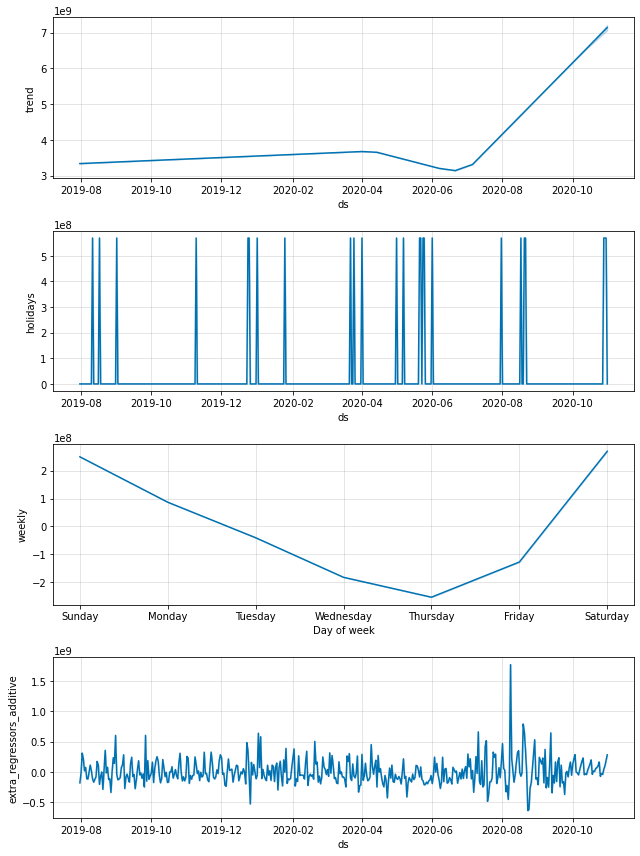

In [41]:
fig = model_kas_echannel.plot_components(forecast_kas_echannel)

In [42]:
forecasted_kas_kantor = forecast_kas_kantor[['ds','yhat']] \
                        .rename(columns={'yhat': 'y'})
forecasted_kas_kantor

,ds,y
0,2019-07-31,3.844836e+10
1,2019-08-01,2.504478e+11
2,2019-08-02,1.801709e+11
3,2019-08-03,1.839600e+11
4,2019-08-04,1.915655e+11
...,...,...
451,2020-10-27,1.222308e+13
452,2020-10-28,1.236800e+13
453,2020-10-29,1.250616e+13
454,2020-10-30,1.250423e+13


In [43]:
forecasted_kas_echannel = forecast_kas_echannel[['ds','yhat']] \
                        .rename(columns={'yhat': 'y'})
forecasted_kas_echannel

,ds,y
0,2019-07-31,2.974538e+09
1,2019-08-01,3.058639e+09
2,2019-08-02,3.522873e+09
3,2019-08-03,3.828879e+09
4,2019-08-04,3.611155e+09
...,...,...
451,2020-10-27,6.925005e+09
452,2020-10-28,7.471986e+09
453,2020-10-29,7.487825e+09
454,2020-10-30,7.740797e+09


In [44]:
# submission = pd.read_csv('../input/bri-data-hackathon-cr-optimization/sample_submission.csv')
# submission.iloc[:31,1]=forecasted_kas_kantor.iloc[:,1]
# submission.iloc[31:,1]=forecasted_kas_echannel.iloc[:,1]
# submission.groupby('index').sum()
# submission.to_csv('new_submission3.csv')
# submission.drop(submission.iloc[:,0], inplace=True)

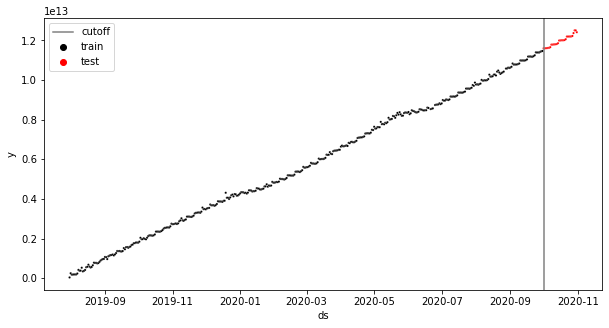

In [45]:
cutoff = pd.to_datetime('2020-10-01')
forecasted_kas_kantor['type'] = forecasted_kas_kantor['ds'].apply(
    lambda date: 'train' if date < cutoff else 'test')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='ds', y='y', hue='type', s=5,
                 palette=['black', 'red'],
                data=forecasted_kas_kantor)
plt.axvline(x=cutoff, color='gray', label='cutoff')
plt.legend()
plt.show()

In [46]:
train1 = forecasted_kas_kantor[forecasted_kas_kantor['ds'] < cutoff]
test1 = forecasted_kas_kantor[forecasted_kas_kantor['ds'] >= cutoff]

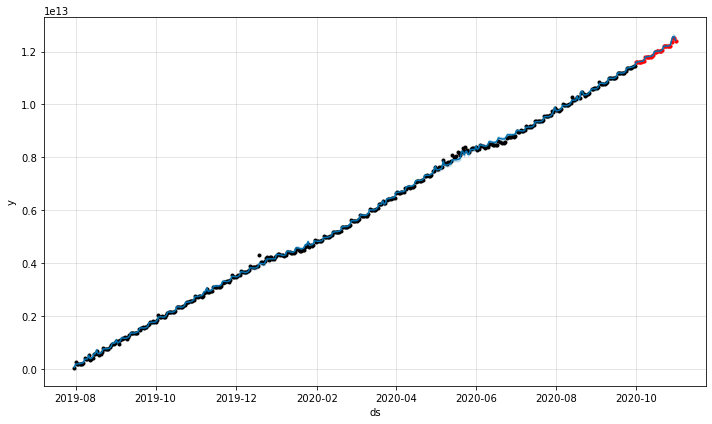

In [47]:
model_final1 = Prophet(
    n_changepoints=10, # trend flexibility
    changepoint_range=0.90, # trend flexibility
    changepoint_prior_scale=0.010, # trend flexibility
    weekly_seasonality=3, # seasonality fourier order
    yearly_seasonality=False, # remove seasonality
    
    holidays=holiday, # holiday effect
    #yearly_seasonality=True
    )
model_final1.add_seasonality(name='monthly', period=30.5, fourier_order=5) # add monthly seasonality
model_final1.fit(train1) # only training set

# forecasting
future_final1 = model_final1.make_future_dataframe(periods=31, freq='D') # 303 days (test size)
forecast_final1 = model_final1.predict(future_final1)

# visualize
fig = model_final1.plot(forecast_final1)
plt.scatter(x=test1['ds'], y=test1['y'], s=10, color='red')
plt.show()

In [48]:
forecasted_final1 = forecast_final1[['ds','yhat']] \
                        .rename(columns={'yhat': 'y'})
forecasted_final1

,ds,y
0,2019-07-31,6.223143e+10
1,2019-08-01,1.894296e+11
2,2019-08-02,1.879057e+11
3,2019-08-03,2.019681e+11
4,2019-08-04,2.045886e+11
...,...,...
451,2020-10-27,1.224074e+13
452,2020-10-28,1.242466e+13
453,2020-10-29,1.256018e+13
454,2020-10-30,1.255594e+13


In [49]:
model_final11 = Prophet(
    n_changepoints=10, # trend flexibility
    changepoint_range=0.90, # trend flexibility
    changepoint_prior_scale=0.010, # trend flexibility
    weekly_seasonality=3, # seasonality fourier order
    yearly_seasonality=False, # remove seasonality
    
    holidays=holiday, # holiday effect
    #yearly_seasonality=True
    )
model_final11.add_seasonality(name='monthly', period=30.5, fourier_order=5) # add monthly seasonality
model_final11.fit(forecasted_final1) # only training set

In [50]:
from sklearn.metrics import mean_squared_log_error
forecast_train = forecast_final1[forecast_final1['ds'] < cutoff]
train_rmsle = mean_squared_log_error(y_true=train1['y'],
                                     y_pred=forecast_train['yhat']) ** 0.5
train_rmsle

0.03376559097144058

In [51]:
forecast_test = forecast_final1[forecast_final1['ds'] >= cutoff]
test_rmsle = mean_squared_log_error(y_true=test1['y'],
                                    y_pred=forecast_test['yhat']) ** 0.5
test_rmsle

0.0016674868841838532

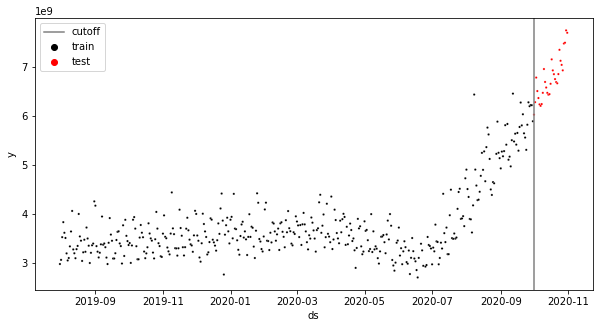

In [52]:
cutoff = pd.to_datetime('2020-10-01')
forecasted_kas_echannel['type'] = forecasted_kas_echannel['ds'].apply(
    lambda date: 'train' if date < cutoff else 'test')

plt.figure(figsize=(10, 5))
sns.scatterplot(x='ds', y='y', hue='type', s=5,
                palette=['black', 'red'],
                data=forecasted_kas_echannel)
plt.axvline(x=cutoff, color='gray', label='cutoff')
plt.legend()
plt.show()

In [53]:
train2 = forecasted_kas_echannel[forecasted_kas_echannel['ds'] < cutoff]
test2 = forecasted_kas_echannel[forecasted_kas_echannel['ds'] >= cutoff]

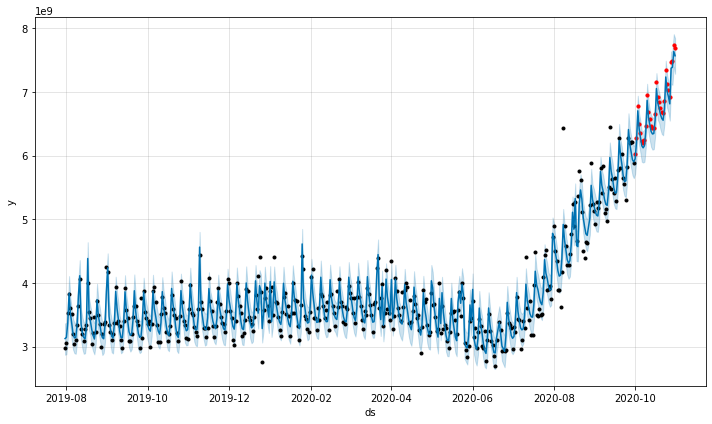

In [54]:
model_final2 = Prophet(
#      n_changepoints=10, # trend flexibility
#     changepoint_range=0.90, # trend flexibility
#     changepoint_prior_scale=0.010, # trend flexibility
#     weekly_seasonality=3, # seasonality fourier order
#     yearly_seasonality=False, # remove seasonality
    holidays=holiday, # holiday effect
    
    #yearly_seasonality=True
    )
model_final2.add_seasonality(name='monthly', period=30.5, fourier_order=5) # add monthly seasonality
model_final2.fit(train2) # only training set

# forecasting
future_final2 = model_final2.make_future_dataframe(periods=31, freq='D') # 303 days (test size)
forecast_final2 = model_final2.predict(future_final2)

# visualize
fig = model_final2.plot(forecast_final2)
plt.scatter(x=test2['ds'], y=test2['y'], s=10, color='red')
plt.show()

In [55]:
forecasted_final2 = forecast_final2[['ds','yhat']] \
                        .rename(columns={'yhat': 'y'})
forecasted_final2

,ds,y
0,2019-07-31,3.125341e+09
1,2019-08-01,3.144058e+09
2,2019-08-02,3.366824e+09
3,2019-08-03,3.837520e+09
4,2019-08-04,3.530890e+09
...,...,...
451,2020-10-27,6.812064e+09
452,2020-10-28,7.373210e+09
453,2020-10-29,7.385165e+09
454,2020-10-30,7.634852e+09


In [56]:
model_final22 = Prophet(
    holidays=holiday, # holiday effect
    #yearly_seasonality=True
    )
model_final22.add_seasonality(name='monthly', period=30.5, fourier_order=5) # add monthly seasonality
model_final22.fit(forecasted_final2) # only training set

In [57]:
forecast_train = forecast_final2[forecast_final2['ds'] < cutoff]
train_rmsle = mean_squared_log_error(y_true=train2['y'],
                                     y_pred=forecast_train['yhat']) ** 0.5
train_rmsle

0.048767565138048335

In [58]:
forecast_test = forecast_final2[forecast_final2['ds'] >= cutoff]
test_rmsle = mean_squared_log_error(y_true=test2['y'],
                                    y_pred=forecast_test['yhat']) ** 0.5
test_rmsle

0.014065494164282957

In [59]:
a1 = forecast_final1['yhat'].iloc[-31:]
a2 = forecast_final2['yhat'].iloc[-31:]
submission = pd.read_csv('../input/bri-data-hackathon-cr-optimization/sample_submission.csv')
submission.iloc[:31,1]=a1
submission.iloc[31:,1]=a2
submission.groupby('index').sum()
submission.to_csv('new_submission5.csv')

In [60]:
from fbprophet.diagnostics import cross_validation
df_cv1 = cross_validation(model_final11, initial='250 days', horizon='31 days', period='25 days')
df_cv1

  0%|          | 0/8 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-09,6.876686e+12,6.868127e+12,6.885446e+12,6.888687e+12,2020-04-08
1,2020-04-10,6.883307e+12,6.874726e+12,6.891687e+12,6.895333e+12,2020-04-08
2,2020-04-11,6.898325e+12,6.889354e+12,6.907588e+12,6.910504e+12,2020-04-08
3,2020-04-12,6.896084e+12,6.886635e+12,6.904876e+12,6.908250e+12,2020-04-08
4,2020-04-13,6.901469e+12,6.892561e+12,6.910484e+12,6.913342e+12,2020-04-08
...,...,...,...,...,...,...
239,2020-10-27,1.224073e+13,1.219814e+13,1.230351e+13,1.224074e+13,2020-09-30
240,2020-10-28,1.242466e+13,1.237615e+13,1.249245e+13,1.242466e+13,2020-09-30
241,2020-10-29,1.256017e+13,1.250904e+13,1.263295e+13,1.256018e+13,2020-09-30
242,2020-10-30,1.255593e+13,1.250058e+13,1.263306e+13,1.255594e+13,2020-09-30


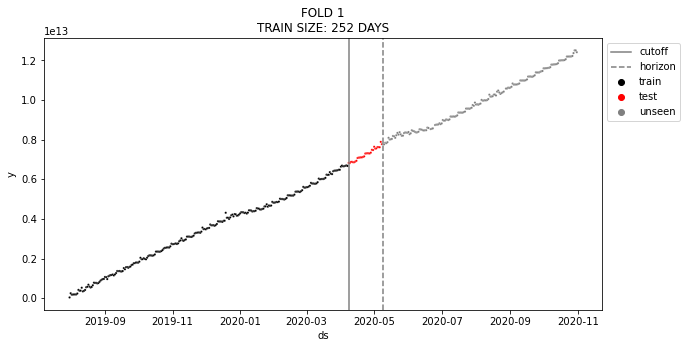

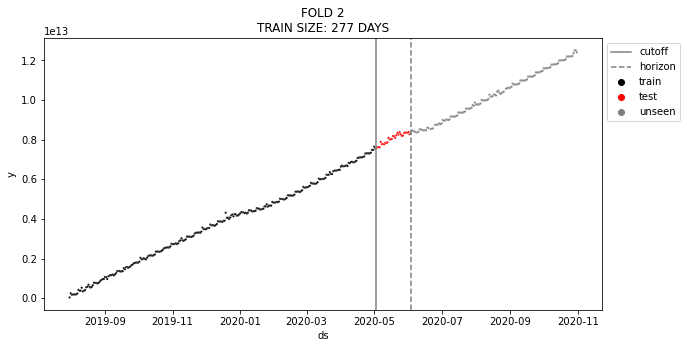

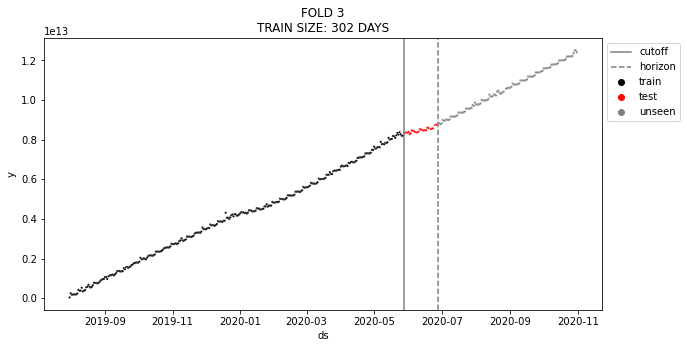

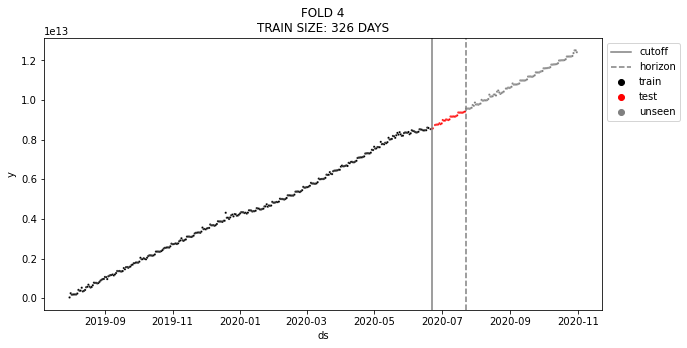

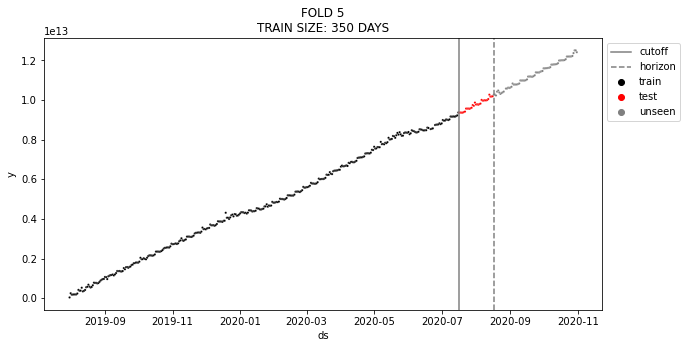

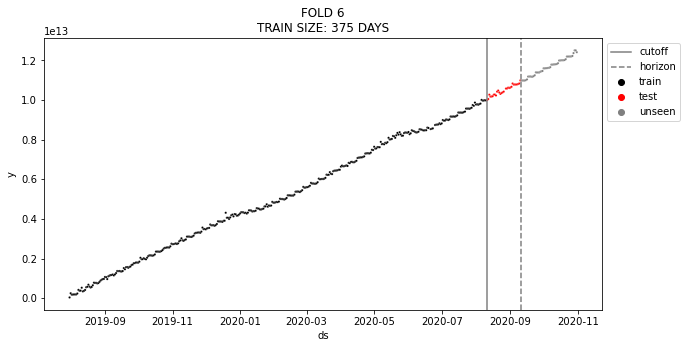

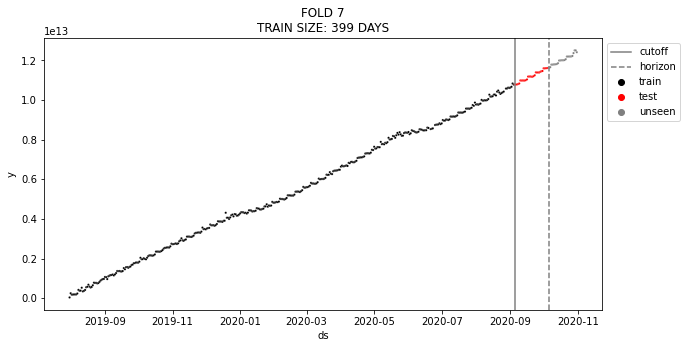

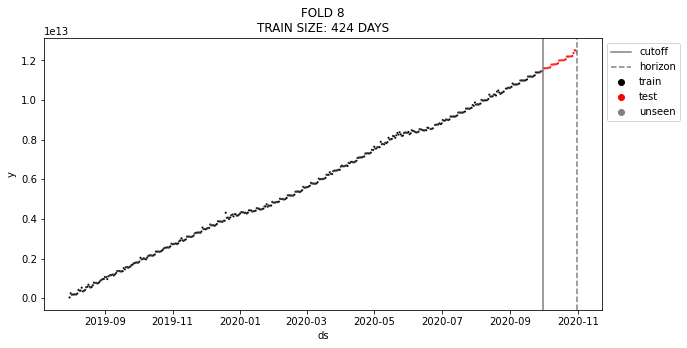

In [61]:
df_copy = forecasted_kas_kantor[['ds', 'y']].copy()
df_cutoff_horizon = df_cv1.groupby('cutoff')[['ds']].max()

for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
  horizon_cutoff = horizon['ds']

  df_copy['type'] = df_copy['ds'].apply(
      lambda date: 'train' if date < cutoff else 
                   'test' if date < horizon_cutoff else 'unseen')
  
  plt.figure(figsize=(10, 5))
  sns.scatterplot(x='ds', y='y', hue='type', s=5,
                  palette=['black', 'red', 'gray'],
                  data=df_copy)
  plt.axvline(x=cutoff, color='gray', label='cutoff')
  plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
  plt.show()

In [62]:
df_cv2 = cross_validation(model_final22, initial='250 days', horizon='31 days', period='25 days')
df_cv2

  0%|          | 0/8 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-04-09,3.396876e+09,3.388451e+09,3.406038e+09,3.352714e+09,2020-04-08
1,2020-04-10,3.570851e+09,3.562261e+09,3.579235e+09,3.520910e+09,2020-04-08
2,2020-04-11,4.029579e+09,4.021505e+09,4.037958e+09,3.974736e+09,2020-04-08
3,2020-04-12,3.757681e+09,3.749074e+09,3.766595e+09,3.698589e+09,2020-04-08
4,2020-04-13,3.631772e+09,3.622942e+09,3.640535e+09,3.568712e+09,2020-04-08
...,...,...,...,...,...,...
239,2020-10-27,6.811831e+09,6.757097e+09,6.864997e+09,6.812064e+09,2020-09-30
240,2020-10-28,7.372896e+09,7.315315e+09,7.428847e+09,7.373210e+09,2020-09-30
241,2020-10-29,7.384865e+09,7.322591e+09,7.444842e+09,7.385165e+09,2020-09-30
242,2020-10-30,7.634577e+09,7.569600e+09,7.696927e+09,7.634852e+09,2020-09-30


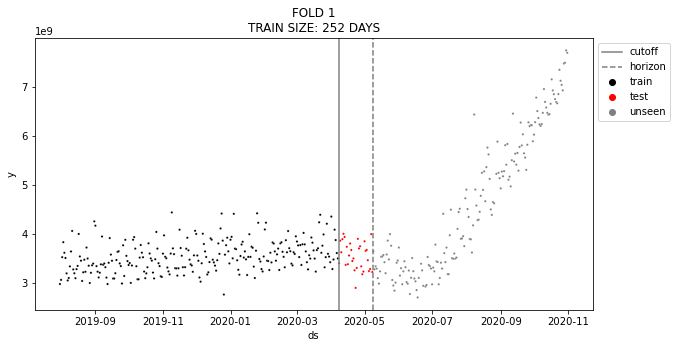

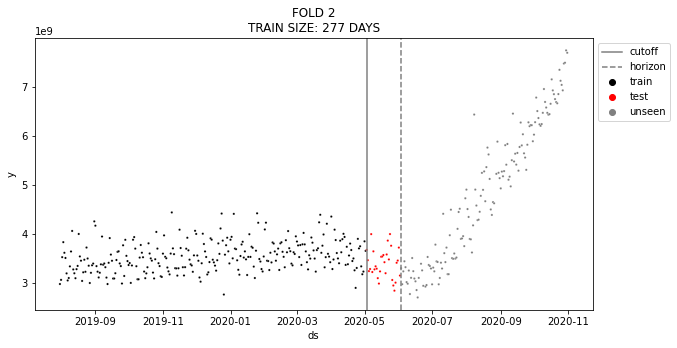

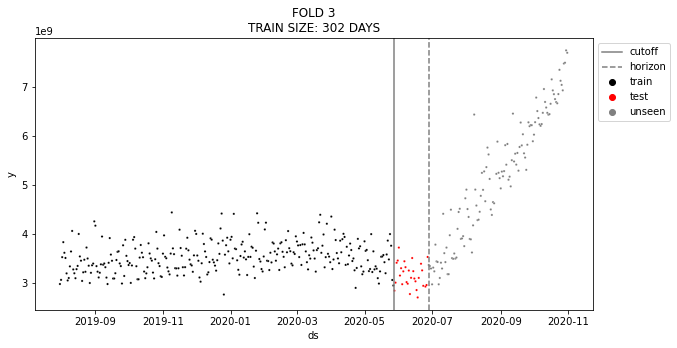

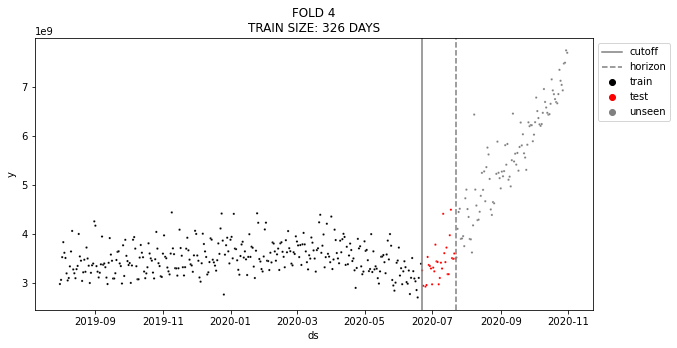

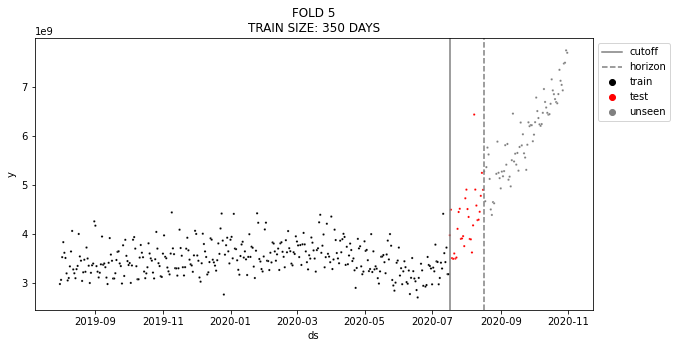

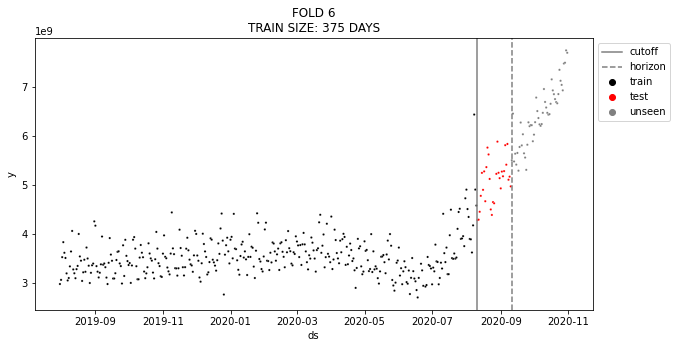

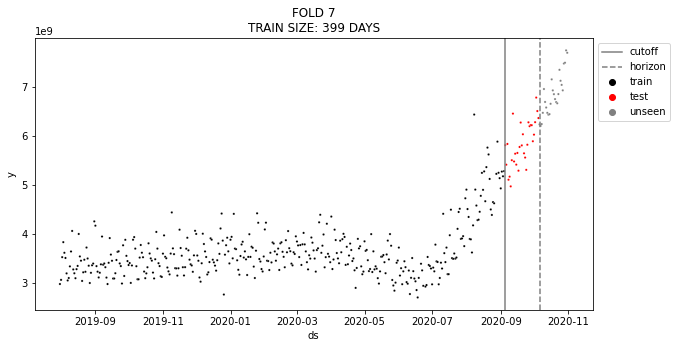

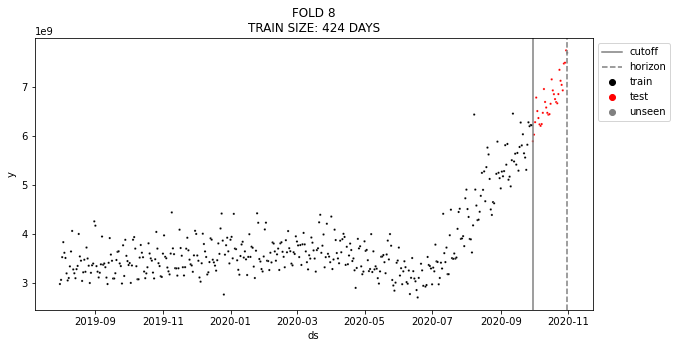

In [63]:
df_copy = forecasted_kas_echannel[['ds', 'y']].copy()
df_cutoff_horizon = df_cv2.groupby('cutoff')[['ds']].max()

for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
  horizon_cutoff = horizon['ds']

  df_copy['type'] = df_copy['ds'].apply(
      lambda date: 'train' if date < cutoff else 
                   'test' if date < horizon_cutoff else 'unseen')
  
  plt.figure(figsize=(10, 5))
  sns.scatterplot(x='ds', y='y', hue='type', s=5,
                  palette=['black', 'red', 'gray'],
                  data=df_copy)
  plt.axvline(x=cutoff, color='gray', label='cutoff')
  plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
  plt.show()

In [64]:
from sklearn.metrics import mean_squared_log_error
cv_rmsle1 = df_cv1.groupby('cutoff').apply(
    lambda x: mean_squared_log_error(y_true=x['y'],
                                     y_pred=x['yhat']) ** 0.5)
cv_rmsle1

cutoff
2020-04-08    2.477844e-03
2020-05-03    1.112923e-02
2020-05-28    1.196891e-02
2020-06-22    6.368618e-03
2020-07-17    2.178473e-02
2020-08-11    4.782955e-03
2020-09-05    2.959100e-03
2020-09-30    3.316543e-07
dtype: float64

In [65]:
cv_rmsle1.mean()

0.007683964116100208

In [66]:
cv_rmsle2 = df_cv2.groupby('cutoff').apply(
    lambda x: mean_squared_log_error(y_true=x['y'],
                                     y_pred=x['yhat']) ** 0.5)
cv_rmsle2

cutoff
2020-04-08    0.040000
2020-05-03    0.026106
2020-05-28    0.028834
2020-06-22    0.179905
2020-07-17    0.233262
2020-08-11    0.131363
2020-09-05    0.032792
2020-09-30    0.000031
dtype: float64

In [67]:
cv_rmsle2.mean()

0.08403672999547206

In [68]:
a = df_cv1['yhat'].iloc[-31:]
b = df_cv2['yhat'].iloc[-31:]

In [69]:
a

213    1.160185e+13
214    1.160157e+13
215    1.161688e+13
216    1.162075e+13
217    1.162985e+13
218    1.163947e+13
219    1.167393e+13
220    1.179888e+13
221    1.179788e+13
222    1.181225e+13
223    1.181370e+13
224    1.182096e+13
225    1.183249e+13
226    1.187322e+13
227    1.200550e+13
228    1.200814e+13
229    1.202046e+13
230    1.201665e+13
231    1.201992e+13
232    1.203099e+13
233    1.207283e+13
234    1.220388e+13
235    1.220166e+13
236    1.220883e+13
237    1.220515e+13
238    1.221657e+13
239    1.224073e+13
240    1.242466e+13
241    1.256017e+13
242    1.255593e+13
243    1.242869e+13
Name: yhat, dtype: float64

In [70]:
submission = pd.read_csv('../input/bri-data-hackathon-cr-optimization/sample_submission.csv')
submission.iloc[:31,1]=a
submission.iloc[31:,1]=b
submission.groupby('index').sum()
submission.to_csv('new_submission9.csv')

## Hyperparameter Tuning

In [71]:
from tqdm import tqdm
import itertools

# Grid search parameters (TO DO: specify possible values)
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01],
    'changepoint_range': [0.7,0.8, 0.9, 0.95],
    'n_changepoints' : [10], # trend flexibility
    'weekly_seasonality' : [3,2,5], # seasonality fourier order
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []  # Store the RMSLEs for each params here

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
  # fitting model
  # (TO DO: change the data and add other components: seasonality, holiday, regressor)
  model = Prophet(**params, yearly_seasonality=False,
                  holidays=holiday)
#   model.add_regressor('cash_in_echannel')
#   model.add_regressor('cash_out_echannel')
  model.fit(forecasted_kas_kantor)

  # Expanding window cross validation (TO DO: use different values)
  cv = cross_validation(model, initial='250 days', period='31 days', horizon='48 days',
                        parallel='processes')
  
  # Evaluation metrics: RMSLE
  rmsle = cv.groupby('cutoff').apply(
      lambda x: mean_squared_log_error(y_true=x['y'],
                                       y_pred=x['yhat']) ** 0.5)
  
  mean_rmsle = rmsle.mean()
  rmsles.append(mean_rmsle)

100%|██████████| 24/24 [02:13<00:00,  5.57s/it]


In [72]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by='rmsle')

,changepoint_prior_scale,changepoint_range,n_changepoints,weekly_seasonality,rmsle
18,0.010,0.90,10,3,0.015412
19,0.010,0.90,10,2,0.015668
20,0.010,0.90,10,5,0.015723
3,0.001,0.80,10,3,0.016582
4,0.001,0.80,10,2,0.016778
11,0.001,0.95,10,5,0.016876
5,0.001,0.80,10,5,0.016921
10,0.001,0.95,10,2,0.016931
1,0.001,0.70,10,2,0.016948
8,0.001,0.90,10,5,0.016971


In [73]:
best_params = all_params[np.argmin(rmsles)]
best_params

{'changepoint_prior_scale': 0.01,
 'changepoint_range': 0.9,
 'n_changepoints': 10,
 'weekly_seasonality': 3}

In [74]:
# Grid search parameters (TO DO: specify possible values)
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01],
    'changepoint_range': [0.7,0.8, 0.9, 0.95],
    'n_changepoints' : [10], # trend flexibility
    'weekly_seasonality' : [3,2,5], # seasonality fourier order
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []  # Store the RMSLEs for each params here

# Use cross validation to evaluate all parameters
for params in tqdm(all_params):
  # fitting model
  # (TO DO: change the data and add other components: seasonality, holiday, regressor)
  model = Prophet(**params, yearly_seasonality=False,
                  holidays=holiday)
#   model.add_regressor('cash_in_echannel')
#   model.add_regressor('cash_out_echannel')
  model.fit(forecasted_kas_echannel)

  # Expanding window cross validation (TO DO: use different values)
  cv = cross_validation(model, initial='250 days', period='31 days', horizon='48 days',
                        parallel='processes')
  
  # Evaluation metrics: RMSLE
  rmsle = cv.groupby('cutoff').apply(
      lambda x: mean_squared_log_error(y_true=x['y'],
                                       y_pred=x['yhat']) ** 0.5)
  
  mean_rmsle = rmsle.mean()
  rmsles.append(mean_rmsle)

100%|██████████| 24/24 [02:09<00:00,  5.41s/it]


In [75]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmsle'] = rmsles
tuning_results.sort_values(by='rmsle')

,changepoint_prior_scale,changepoint_range,n_changepoints,weekly_seasonality,rmsle
18,0.010,0.90,10,3,0.196522
15,0.010,0.80,10,3,0.196976
17,0.010,0.80,10,5,0.199523
20,0.010,0.90,10,5,0.203401
21,0.010,0.95,10,3,0.206916
23,0.010,0.95,10,5,0.208991
22,0.010,0.95,10,2,0.213853
19,0.010,0.90,10,2,0.216455
16,0.010,0.80,10,2,0.217699
0,0.001,0.70,10,3,0.226155
